#PROJECT
For the project you will perform sentiment analysis on reviews from amazon.  The data to use is located here: http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
Note it is a gziped json file.  If you'd like to download and extract it directly into colab, this can be done using the following lines:
!curl http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz -o reviews.json.gz
!gunzip reviews.json.gz
To view the file:
!ls

At this point it should be easily ingested into a pandas data frame. A few relevant fields are reviewText: The text from the review
summary: The summary text from the review
overall: The score the reviewer gave the item.


Your task: 
Perform the necessary transformations to train both regression and classification models to predict the 'overall' field in the data set. This should include creating the correctly sized training and test sets.

When performing the classification task, use overall less than 3 as negative, greater than 3 as positive, and 3 as neutral. If you'd prefer a numeric value 0 should be negative, 1 neutral and 2 positive.

You may wish to drop the columns image, style and votes.  You may also wish the drop duplicate data.

There are several options for using the summary and reviewText together, such as concatenating the strings, training separate models on both and feeding those results into another models, etc.  You may find that you don't want to use all fields (other that the ones I suggested dropping). I will let you experiment with this, just explain what you did and why.

You should certainly apply vectorization and perhaps a pca or nmf as well.  Try at least three different classifiers/regressors.  Attempt to get the best possible result, remember the different metrics we discussed for evaluating models.  Discuss which metric you this you should optimize for and why.  Pipelines and grid search will certainly help in optimizing your results!

Write a 5 page or less paper describing your work and the performance you were able to achieve.

In [1]:
import numpy as np
import pandas as pd
import datetime
import csv
import os
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF
from sklearn.naive_bayes import GaussianNB

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!curl http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz -o reviews.json.gz
!gunzip reviews.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  161M  100  161M    0     0  10.1M      0  0:00:15  0:00:15 --:--:-- 11.0M


In [3]:
!ls

reviews.json  sample_data


In [4]:
df=pd.read_json('reviews.json',lines=True)
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN
2,3,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN
3,2,True,"02 4, 2014",A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN
4,4,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1128432,4,True,"12 22, 2016",A1QWMCG1FNEP3A,B01HJC7N4C,NaN,Amazon Customer,Good for viewing. But doesn't have a button or...,Good,1482364800,NaN,NaN
1128433,5,False,"07 15, 2016",A3FOBEJ9UVUTR3,B01HJC7N4C,NaN,David Harlow,I was given the Rockrok 3D VR Glasses Headset ...,THE FUTURE IS NOW!!!!!!!,1468540800,NaN,NaN
1128434,5,False,"07 14, 2016",AMUEAMKB4E33M,B01HJC7N4C,NaN,Tom D,Super Fun! The RockRoc 3d vr headset is waaaay...,Get more out of your smartphone .......,1468454400,NaN,[https://images-na.ssl-images-amazon.com/image...
1128435,5,False,"07 13, 2016",A2EV91MMOJ3IL4,B01HJC7N4C,NaN,Timber12,Love it!\n\nI've had other VR glasses which al...,Join the VR fun train!,1468368000,NaN,NaN


In [5]:
df.isnull().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              523196
reviewerName          135
reviewText            765
summary               517
unixReviewTime          0
vote              1036403
image             1101330
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         1128437 non-null  int64 
 1   verified        1128437 non-null  bool  
 2   reviewTime      1128437 non-null  object
 3   reviewerID      1128437 non-null  object
 4   asin            1128437 non-null  object
 5   style           605241 non-null   object
 6   reviewerName    1128302 non-null  object
 7   reviewText      1127672 non-null  object
 8   summary         1127920 non-null  object
 9   unixReviewTime  1128437 non-null  int64 
 10  vote            92034 non-null    object
 11  image           27107 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 95.8+ MB


In [7]:
df = df.drop(['image','style','vote'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         1128437 non-null  int64 
 1   verified        1128437 non-null  bool  
 2   reviewTime      1128437 non-null  object
 3   reviewerID      1128437 non-null  object
 4   asin            1128437 non-null  object
 5   reviewerName    1128302 non-null  object
 6   reviewText      1127672 non-null  object
 7   summary         1127920 non-null  object
 8   unixReviewTime  1128437 non-null  int64 
dtypes: bool(1), int64(2), object(6)
memory usage: 70.0+ MB


In [8]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400
1,5,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200
2,3,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600
3,2,True,"02 4, 2014",A1M117A53LEI8,7508492919,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000
4,4,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600


In [9]:
df.dropna()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400
1,5,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200
2,3,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600
3,2,True,"02 4, 2014",A1M117A53LEI8,7508492919,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000
4,4,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600
...,...,...,...,...,...,...,...,...,...
1128432,4,True,"12 22, 2016",A1QWMCG1FNEP3A,B01HJC7N4C,Amazon Customer,Good for viewing. But doesn't have a button or...,Good,1482364800
1128433,5,False,"07 15, 2016",A3FOBEJ9UVUTR3,B01HJC7N4C,David Harlow,I was given the Rockrok 3D VR Glasses Headset ...,THE FUTURE IS NOW!!!!!!!,1468540800
1128434,5,False,"07 14, 2016",AMUEAMKB4E33M,B01HJC7N4C,Tom D,Super Fun! The RockRoc 3d vr headset is waaaay...,Get more out of your smartphone .......,1468454400
1128435,5,False,"07 13, 2016",A2EV91MMOJ3IL4,B01HJC7N4C,Timber12,Love it!\n\nI've had other VR glasses which al...,Join the VR fun train!,1468368000


In [10]:
df.overall.value_counts()

5    707038
4    184431
3     98254
1     81539
2     57175
Name: overall, dtype: int64

In [11]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400
1,5,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200
2,3,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600
3,2,True,"02 4, 2014",A1M117A53LEI8,7508492919,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000
4,4,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600


In [0]:
df['review'] = df['reviewText'] + df['summary']

In [0]:
df['sentiment'] = 0

In [0]:
# Sentiment 
# 2 is Positive, score above 3
# 1 is Neutral, score = 3
# 0 is Negative, score below 3

df.loc[df['overall']>3,'sentiment'] = 2
df.loc[df['overall']==3,'sentiment'] = 1
df.loc[df['overall']<3,'sentiment'] = 0

In [0]:
# Converting 'Verified' column to int

df.loc[df['verified']==True,'verified']=1
df.loc[df['verified']==False,'verified']=0
df['verified'] = df['verified'].astype('int')

In [0]:
# droping redundant columns from above

df = df.drop(['reviewText', 'summary','overall'],axis=1)

df = df.dropna()

In [17]:
df.head()

,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,review,sentiment
0,1,"08 4, 2014",A24E3SXTC62LJI,7508492919,Claudia Valdivia,1407110400,Looks even better in person. Be careful to not...,2
1,1,"02 12, 2014",A269FLZCB4GIPV,7508492919,sarah ponce,1392163200,When you don't want to spend a whole lot of ca...,2
2,1,"02 8, 2014",AB6CHQWHZW4TV,7508492919,Kai,1391817600,"so the case came on time, i love the design. I...",1
3,1,"02 4, 2014",A1M117A53LEI8,7508492919,Sharon Williams,1391472000,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,0
4,1,"02 3, 2014",A272DUT8M88ZS8,7508492919,Bella Rodriguez,1391385600,"I liked it because it was cute, but the studs ...",2


In [0]:
# dropping other irrelevant columns

df = df.drop(['reviewTime', 'reviewerID','reviewerName','asin'],axis=1)

In [19]:
df.head()

,verified,unixReviewTime,review,sentiment
0,1,1407110400,Looks even better in person. Be careful to not...,2
1,1,1392163200,When you don't want to spend a whole lot of ca...,2
2,1,1391817600,"so the case came on time, i love the design. I...",1
3,1,1391472000,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,0
4,1,1391385600,"I liked it because it was cute, but the studs ...",2


# RE

In [0]:
import re

In [0]:
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        sub = re.sub(i, '', input_text)
    return sub

In [0]:
df['review'] = df['review'].astype(str).replace("[^a-zA-Z0-9$]", " ")

In [0]:
df['review'] = df['review'].str.lower()

In [49]:
df[['review']].head(6)

,review
0,0.0
1,0.0
2,0.0
3,0.0002931355545956573
4,4.488421707844728e-05
5,0.00031633234017963837


In [21]:
df['unixReviewTime']

0          1407110400
1          1392163200
2          1391817600
3          1391472000
4          1391385600
              ...    
1128432    1482364800
1128433    1468540800
1128434    1468454400
1128435    1468368000
1128436    1494460800
Name: unixReviewTime, Length: 1127073, dtype: int64

In [0]:
vectorizer = TfidfVectorizer(stop_words="english")

In [0]:
vec_review = vectorizer.fit_transform(df['review'])

In [24]:
columns = vectorizer.get_feature_names()
columns

['00',
 '000',
 '0000',
 '000000',
 '0000000',
 '00000000000000001',
 '000000000001',
 '000000001',
 '00000001',
 '0000001',
 '000001',
 '00001',
 '00001131',
 '00009',
 '0000mah',
 '0001',
 '0001000f_pid',
 '0002',
 '0004',
 '000405',
 '0007',
 '00092',
 '000a',
 '000ah',
 '000amh',
 '000amp',
 '000ft',
 '000hz',
 '000k',
 '000kbps',
 '000m',
 '000ma',
 '000mah',
 '000mahgood',
 '000mahi',
 '000mahm',
 '000mamph',
 '000mha',
 '000milliamp',
 '000s',
 '000th',
 '000very',
 '000x',
 '001',
 '001g',
 '001mm',
 '002',
 '0024',
 '00241cf738a3_c00000000',
 '002mah',
 '003',
 '003070',
 '003395',
 '0038',
 '00393701',
 '004',
 '0041',
 '0042',
 '004v',
 '005',
 '0057',
 '005v',
 '0066',
 '007',
 '008',
 '00805f9b34fb',
 '008g',
 '009',
 '0090',
 '009340',
 '00a',
 '00am',
 '00arrived',
 '00awesome',
 '00b29',
 '00best',
 '00beware',
 '00biggest',
 '00cool',
 '00cute',
 '00do',
 '00does',
 '00doesnt',
 '00double',
 '00durable',
 '00ea',
 '00five',
 '00four',
 '00good',
 '00gorilla',
 '00grand

# NMF

In [0]:
nmf1=NMF(n_components=10)
review_nmf=nmf1.fit_transform(vec_review)


In [26]:
review_nmf[:,0]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.01739189])

In [0]:
df['review']=review_nmf[:,0]

In [28]:
df.head(10)

,verified,unixReviewTime,review,sentiment
0,1,1407110400,0.000000,2
1,1,1392163200,0.000000,2
2,1,1391817600,0.000000,1
3,1,1391472000,0.000293,0
4,1,1391385600,0.000045,2
5,1,1390780800,0.000316,0
6,1,1390435200,0.000027,1
7,1,1389916800,0.000000,2
8,1,1388102400,0.000116,0
9,1,1387152000,0.000000,2


# **Classification**. 

In [0]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df.drop('sentiment',axis=1), df.sentiment, test_size=0.3,random_state=2)

In [0]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [31]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7884195645358776


In [32]:
print(confusion_matrix(gnb.predict(df.drop('sentiment',axis=1)),df['sentiment']))

[[   712    468   2420]
 [     0      0      0]
 [137894  97710 887869]]


MULTIBINOMIAL NB

In [33]:
c1 = MultinomialNB()
time = datetime.datetime.now()
c1.fit(X_train, y_train)
print(datetime.datetime.now() - time)

0:00:00.160800


In [34]:
preds = c1.predict(X_test)
print("MultinomialNB: ",list(preds[:10]))
print("Actual: ",y_test[:10])

MultinomialNB:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Actual:  544549    2
631773    0
294069    2
686835    2
493995    0
358000    1
691075    2
279829    2
753725    2
642989    2
Name: sentiment, dtype: int64


In [35]:
print(classification_report(y_test, preds))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     41752
           1       0.00      0.00      0.00     29271
           2       0.79      1.00      0.88    267099

    accuracy                           0.79    338122
   macro avg       0.26      0.33      0.29    338122
weighted avg       0.62      0.79      0.70    338122



LOGISTIC MODEL

In [36]:
c2 = LogisticRegression()
time = datetime.datetime.now()
c2.fit(X_train, y_train)
print(datetime.datetime.now() - time)

0:00:05.697921


#EDA

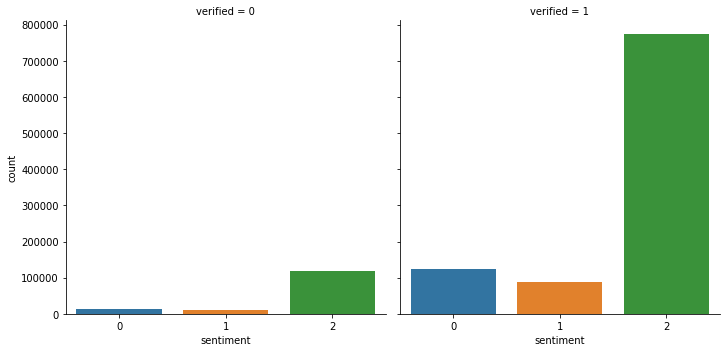

In [37]:
sns.catplot(x="sentiment",col="verified",data=df,kind="count");

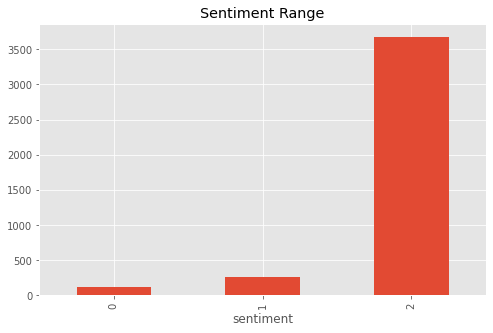

In [38]:
plt.style.use("ggplot")
df.groupby('sentiment')['review'].sum().plot(kind='bar',figsize=(8, 5),
                                                 title="Sentiment Range")

In [39]:
from sklearn.tree import DecisionTreeClassifier
RSEED= 1
# Make a decision tree and train
x= X_test
y= y_test
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(x, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')